## Time Series Forecasting (Research Lab,2023)

Rossmann Store Sales Forecast 

Rossmann operates over 3,000 drugstores in 7 European countries. Currently, Rossmann store managers have to forecast their daily sales up to six weeks in advance. Store sales are influenced by many factors, such as promotions, competition, school and public holidays, seasonal and local conditions. Because thousands of store managers forecast sales based on their individual circumstances, the accuracy of results can vary widely. This booklet focuses primarily on time series analysis (seasonal decomposition, trends, autocorrelation).

Steps to be performed

1.Data pre-processing and cleaning                                                                                               
2.Visualize the data                                                                                                             
3.Make the time series data stationary, if required                                                                             
4.Plot correlation and auto-correlation charts                                                                                   
5.Selection of the parameters and building of model for the plotting                                                             
6.Use the model to make the required predictions 

In [1]:
#!pip install xgboost
#!pip install pmdarima

In [2]:
!pip install fbprophet

^C


In [95]:
from prophet import Prophet

In [96]:
# importing all the required libraries

#for data manipulation and calculations
import numpy as np
import pandas as pd
from datetime import datetime
from time import time

#for data plotting and visualizations
import matplotlib.pyplot as plt 
import seaborn as sns
#matplotlib inline
import itertools
from scipy import stats

#for time series analysis
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# prophet by Facebook
#from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

Dataset

I have taken the dataset of Rossman Stores sales data from the Kaggle website. The dataset included 3 csv files, store.csv, train.csv and test.csv.
Using the train.csv and test.csv, the model can be trained to perform the required predictions. 
Additional store.csv is given to work upon the feature selection and to check whether the data is stationary or not.

Link for the dataset - https://www.kaggle.com/competitions/rossmann-store-sales/data

In [97]:
#importing training dataset

train = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/train.csv")
test = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/test.csv")
store = pd.read_csv("C:/Ravi Singh/Semester 3/Research Lab/rossmann-store-sales/store.csv")

In [98]:
#train = train.set_index('Date')

In [99]:
train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [101]:
#checking the train data
train.head().append(train.tail())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [102]:
#checking the test data
test.head().append(test.tail())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.00,1,0,0
1,2,3,4,2015-09-17,1.00,1,0,0
2,3,7,4,2015-09-17,1.00,1,0,0
3,4,8,4,2015-09-17,1.00,1,0,0
4,5,9,4,2015-09-17,1.00,1,0,0
41083,41084,1111,6,2015-08-01,1.00,0,0,0
41084,41085,1112,6,2015-08-01,1.00,0,0,0
41085,41086,1113,6,2015-08-01,1.00,0,0,0
41086,41087,1114,6,2015-08-01,1.00,0,0,0
41087,41088,1115,6,2015-08-01,1.00,0,0,1


In [103]:
#checking the store data
store.head().append(store.tail())
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00,1112.00,761.00,761.00,1115.00,571.00,571.00
mean,558.00,5404.90,7.22,2008.67,0.51,23.60,2011.76
std,322.02,7663.17,3.21,6.20,0.50,14.14,1.67
min,1.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,279.50,717.50,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,2325.00,8.00,2010.00,1.00,22.00,2012.00
75%,836.50,6882.50,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


EXPLORATORY DATA ANALYSIS (EDA) on the given dataset:

To perform data cleaning, data pre-processing, checking the sales trend that vary with different factors.

In [104]:
display(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [105]:
display(test.isnull().sum())

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [106]:
display(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [107]:
display(test[pd.isnull(test.Open)])

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [108]:
# replacing the null values with 1
test.fillna(1, inplace=True)

In [109]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

In [110]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [111]:
# for working with the Sarima Model

train1 = train
train2 = pd.merge(train1, store, on='Store')   

# for working with the Xgboost model

df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

In [112]:
#combining the two features to create a new feature that describes average sales per customer

train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2.shape

(1017209, 19)

In [113]:
def features_create(data):
    
    data['Date'] = pd.to_datetime(data['Date'])

    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [114]:
features_create(df_train_store)
features_create(df_test_store)
features_create(train2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,3,...,,9.48,2015,7,31,31,82.00,24187.75,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1,3,...,,9.19,2015,7,30,31,82.00,24187.75,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1,3,...,,9.14,2015,7,29,31,82.00,24187.75,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1,3,...,,8.95,2015,7,28,31,82.00,24187.75,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1,3,...,,9.97,2015,7,27,31,82.00,24187.75,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5,2013-01-05,4771,339,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",14.07,2013,1,5,1,24157.00,6.75,Jan,0
1017205,1115,4,2013-01-04,4540,326,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",13.93,2013,1,4,1,24157.00,6.75,Jan,0
1017206,1115,3,2013-01-03,4297,300,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",14.32,2013,1,3,1,24157.00,6.75,Jan,0
1017207,1115,2,2013-01-02,3697,305,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",12.12,2013,1,2,1,24157.00,6.75,Jan,0


In [115]:
#plotting the trends of sales, customers and sales/cutomer to check whether these trends are affected by the store type and the promotional events.

#sns.factorplot(data = train2, x = 'Month', y = "Sales", 
#col = 'StoreType', #for different store types
#hue = 'StoreType',
#row = 'Promo', #for different promos
#) 

<AxesSubplot:>

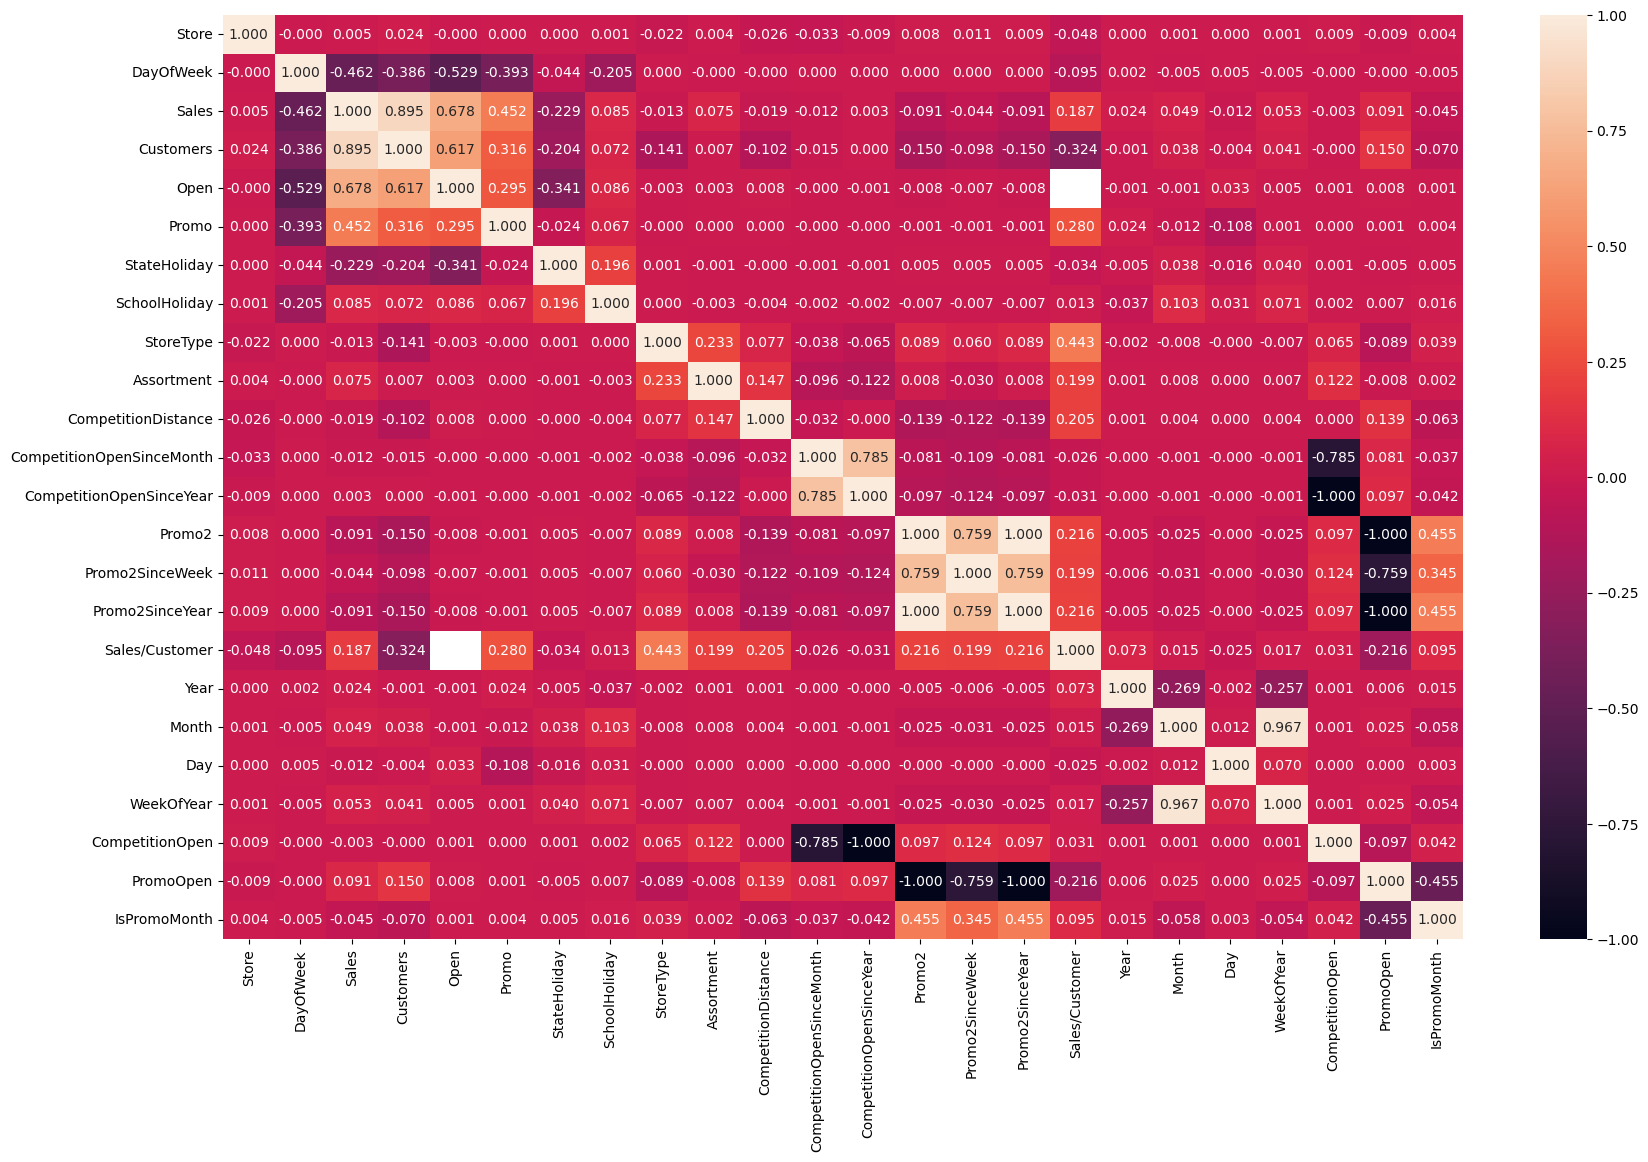

In [116]:
plt.figure(figsize = (20,12))

sns.heatmap(train2.corr(),annot = True, fmt = '.3f',vmin = -1,vmax = 1)

In [117]:
train2 = train2.set_index('Date')

In [118]:
train2

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,3,1,...,,9.48,2015,7,31,31,82.00,24187.75,Jul,0
2015-07-30,1,3,5020,546,1,1,0,1,3,1,...,,9.19,2015,7,30,31,82.00,24187.75,Jul,0
2015-07-29,1,2,4782,523,1,1,0,1,3,1,...,,9.14,2015,7,29,31,82.00,24187.75,Jul,0
2015-07-28,1,1,5011,560,1,1,0,1,3,1,...,,8.95,2015,7,28,31,82.00,24187.75,Jul,0
2015-07-27,1,0,6102,612,1,1,0,1,3,1,...,,9.97,2015,7,27,31,82.00,24187.75,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,5,4771,339,1,0,0,1,4,3,...,"Mar,Jun,Sept,Dec",14.07,2013,1,5,1,24157.00,6.75,Jan,0
2013-01-04,1115,4,4540,326,1,0,0,1,4,3,...,"Mar,Jun,Sept,Dec",13.93,2013,1,4,1,24157.00,6.75,Jan,0
2013-01-03,1115,3,4297,300,1,0,0,1,4,3,...,"Mar,Jun,Sept,Dec",14.32,2013,1,3,1,24157.00,6.75,Jan,0


In [119]:
train2['Sales'] = train2['Sales'] * 1.0

sales_a = train2[train2.Store == 2]['Sales']
sales_b = train2[train2.Store == 85]['Sales']
sales_c = train2[train2.Store == 1]['Sales']
sales_d = train2[train2.Store == 13]['Sales']

# sales_a.describe()
print(sales_a)

Date
2015-07-31   6064.00
2015-07-30   5567.00
2015-07-29   6402.00
2015-07-28   5671.00
2015-07-27   6627.00
               ...  
2013-01-05   2342.00
2013-01-04   4484.00
2013-01-03   4159.00
2013-01-02   4422.00
2013-01-01      0.00
Name: Sales, Length: 942, dtype: float64


In [197]:
#working on the training dataset to make predictions, to compare it with the ground truth as we dont have ground truth in our test data set

#ar_train = train2[6*10*1115:]
#ar_test = train2[:6*10*1115]
#ar_test


# Specify the date to split on (e.g., '2023-01-01')
split_date = '2015-01-01'

# Create the training set (before the split date)
ar_train = train2[train2.index < split_date]
#ar_train = train2

# Create the testing set (after or on the split date)
ar_test = train2[train2.index >= split_date]

ar_train
ar_train.shape,ar_test.shape

((780829, 26), (236380, 26))

In [198]:
ar_train

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,1,2,2605.00,327,1,0,0,1,3,1,...,,7.97,2014,12,31,1,75.00,24168.25,Dec,0
2014-12-30,1,1,6466.00,703,1,0,0,1,3,1,...,,9.20,2014,12,30,1,75.00,24168.25,Dec,0
2014-12-29,1,0,6463.00,700,1,0,0,1,3,1,...,,9.23,2014,12,29,1,75.00,24168.25,Dec,0
2014-12-28,1,6,0.00,0,0,0,0,1,3,1,...,,NaN,2014,12,28,52,75.00,24181.00,Dec,0
2014-12-27,1,5,6057.00,684,1,0,0,1,3,1,...,,8.86,2014,12,27,52,75.00,24181.00,Dec,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,5,4771.00,339,1,0,0,1,4,3,...,"Mar,Jun,Sept,Dec",14.07,2013,1,5,1,24157.00,6.75,Jan,0
2013-01-04,1115,4,4540.00,326,1,0,0,1,4,3,...,"Mar,Jun,Sept,Dec",13.93,2013,1,4,1,24157.00,6.75,Jan,0
2013-01-03,1115,3,4297.00,300,1,0,0,1,4,3,...,"Mar,Jun,Sept,Dec",14.32,2013,1,3,1,24157.00,6.75,Jan,0


MODEL 3 - PROPHET MODEL                                                                                                                                                                                                                                           
Prophet is an open-source tool by Facebook. This procedure is used for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

In [212]:
# Creating a train dataset
train_prophet = ar_train.copy()
train_prophet.reset_index(level=0, inplace=True)
train_prophet.head(3)
t_prophet= train_prophet
t_prophet.head(3)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,2014-12-31,1,2,2605.00,327,1,0,0,1,3,...,,7.97,2014,12,31,1,75.00,24168.25,Dec,0
1,2014-12-30,1,1,6466.00,703,1,0,0,1,3,...,,9.20,2014,12,30,1,75.00,24168.25,Dec,0
2,2014-12-29,1,0,6463.00,700,1,0,0,1,3,...,,9.23,2014,12,29,1,75.00,24168.25,Dec,0


In [213]:
#creating a test dataset
test_prophet = ar_test.copy()
test_prophet.reset_index(level=0, inplace=True)
test_prophet

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Sales/Customer,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,2015-07-31,1,4,5263.00,555,1,1,0,1,3,...,,9.48,2015,7,31,31,82.00,24187.75,Jul,0
1,2015-07-30,1,3,5020.00,546,1,1,0,1,3,...,,9.19,2015,7,30,31,82.00,24187.75,Jul,0
2,2015-07-29,1,2,4782.00,523,1,1,0,1,3,...,,9.14,2015,7,29,31,82.00,24187.75,Jul,0
3,2015-07-28,1,1,5011.00,560,1,1,0,1,3,...,,8.95,2015,7,28,31,82.00,24187.75,Jul,0
4,2015-07-27,1,0,6102.00,612,1,1,0,1,3,...,,9.97,2015,7,27,31,82.00,24187.75,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236375,2015-01-05,1115,0,9102.00,580,1,1,0,1,4,...,"Mar,Jun,Sept,Dec",15.69,2015,1,5,2,24181.00,31.00,Jan,0
236376,2015-01-04,1115,6,0.00,0,0,0,0,1,4,...,"Mar,Jun,Sept,Dec",NaN,2015,1,4,1,24181.00,30.75,Jan,0
236377,2015-01-03,1115,5,6468.00,469,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",13.79,2015,1,3,1,24181.00,30.75,Jan,0
236378,2015-01-02,1115,4,7558.00,539,1,0,0,1,4,...,"Mar,Jun,Sept,Dec",14.02,2015,1,2,1,24181.00,30.75,Jan,0


In [214]:
# Converting col names to specific names as required by Prophet library
train_prophet = train_prophet.rename(columns = {'Date': 'ds','Sales': 'y','Open':'open','Promo':'promo'})
train_prophet = train_prophet.set_index("ds")
train_prophet.index = pd.to_datetime(train_prophet.index)

# Downsampling to week because modelling on daily basis takes a lot of time
train_month_prophet = train_prophet.resample("MS").mean()
train_month_prophet = pd.DataFrame(train_month_prophet[['y','open','promo']]) #original
#train_month_prophet

# Reset the index and convert the index column back to a regular column
train_month_prophet = train_month_prophet.reset_index()
train_month_prophet.head()

,ds,y,open,promo
0,2013-01-01,5211.56,0.84,0.32
1,2013-02-01,5494.37,0.85,0.36
2,2013-03-01,5820.35,0.81,0.48
3,2013-04-01,5483.75,0.83,0.40
4,2013-05-01,5364.13,0.76,0.42


In [215]:
#converting the date column to index for the test data and sampling it to month start date
test_prophet = test_prophet.rename(columns = {'Date':'ds','Sales': 'y','Open':'open','Promo':'promo'})
test_prophet = test_prophet.set_index("ds")
test_prophet.index = pd.to_datetime(test_prophet.index)

In [216]:
test_month_prophet = test_prophet.resample("MS").mean()
test_month_prophet = pd.DataFrame(test_month_prophet[['y','open','promo']])
#train_month_prophet

# Reset the index and convert the index column back to a regular column
test_month_prophet = test_month_prophet.reset_index()
test_month_prophet.head()

,ds,y,open,promo
0,2015-01-01,5752.75,0.83,0.48
1,2015-02-01,5710.30,0.86,0.36
2,2015-03-01,5949.13,0.84,0.39
3,2015-04-01,5916.86,0.81,0.40
4,2015-05-01,5472.12,0.75,0.35


In [217]:
# Fitting data to Prophet model
prophet_1 = Prophet()

In [218]:
prophet_1.fit(train_month_prophet)

10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:42 - cmdstanpy - INFO - Chain [1] done processing


In [219]:
#Model Prediction

pd.options.display.float_format = '{:.2f}'.format
future_1 = prophet_1.make_future_dataframe(periods = 7, freq = "MS") 
forecast_1 = prophet_1.predict(future_1)
#forecast_1[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()
#df_reset = df.reset_index(drop=True)
forecast_2 = forecast_1[["ds","yhat"]].tail(7).reset_index(drop=True)

In [220]:
forecast_2['yactual'] = test_month_prophet['y']
forecast_2[["ds","yhat",'yactual']]

,ds,yhat,yactual
0,2015-01-01,6119.63,5752.75
1,2015-02-01,6149.57,5710.30
2,2015-03-01,6176.62,5949.13
3,2015-04-01,6206.56,5916.86
4,2015-05-01,6235.53,5472.12
5,2015-06-01,6265.48,6199.20
6,2015-07-01,6294.45,6142.71


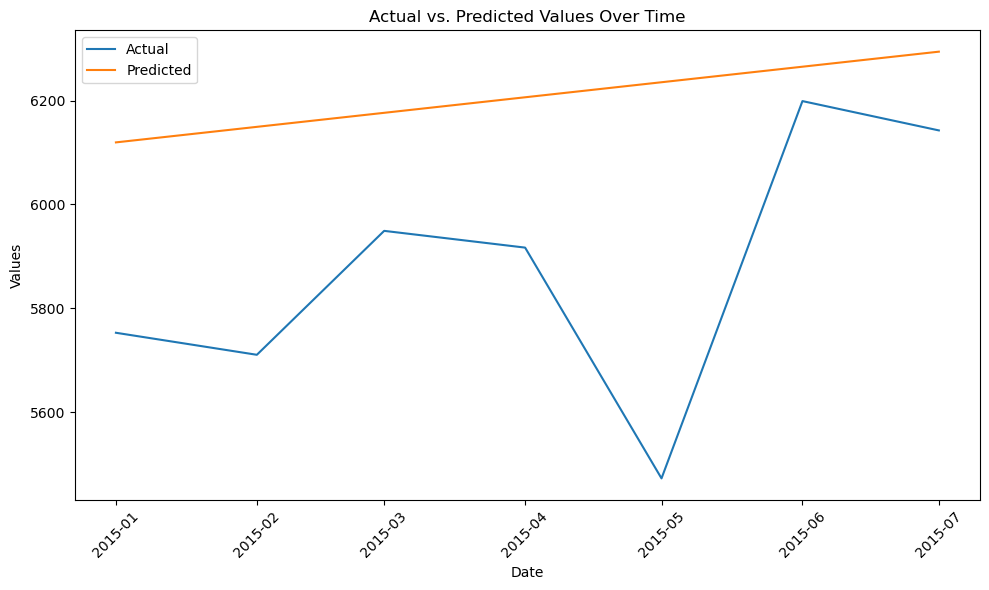

In [221]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the actual values
ax.plot(forecast_2['ds'], forecast_2['yactual'], label='Actual')

# Plot the predicted values
ax.plot(forecast_2['ds'], forecast_2['yhat'], label='Predicted')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('Actual vs. Predicted Values Over Time')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [222]:
# Checking the RMSE of Prophet model

from sklearn.metrics import mean_squared_error
metric_prophet_1 = forecast_1.set_index('ds')[['yhat']].join(test_month_prophet.set_index('ds').y).reset_index()
metric_prophet_1.dropna(inplace=True)
rms_prophet_1 = mean_squared_error(metric_prophet_1.y, metric_prophet_1.yhat)
rmse_p = np.sqrt(rms_prophet_1)
print("Root Mean Square Error for the Prophet Model:",rmse_p)

Root Mean Square Error for the Prophet Model: 391.6010662076827


We used the Root Mean Squared Error (RMSE) to evaluate and validate the performance of various models. 

In [223]:
# Comparing performance of above three models - through RMSE

rmse_arima = format(float(85.28))
rmse_prophet_2 = format(float(rmse_p))
rmse_xgboost_2 = format(float(1354.4484899676445))
rmse_lstm = format(float(157.7961348139355))
model_errors = pd.DataFrame({
    "Model": ["SARIMA","LSTM","Prophet","XGBoost"],
    "RMSE": [rmse_arima, rmse_lstm, rmse_p,rmse_xgboost_2]
})
model_errors
#model_errors.sort_values(by = "RMSE")

,Model,RMSE
0,SARIMA,85.28
1,LSTM,157.7961348139355
2,Prophet,391.60
3,XGBoost,1354.4484899676445
